# 4. Visualizing Facial Expressions
*written by Eshin Jolly*

In this tutorial we'll explore plotting in Py-Feat using functions from the `feat.plotting` module along with plotting methods using the Fex data class. You can try it out interactively in Google Collab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cosanlab/py-feat/blob/master/notebooks/content/05_plotting.ipynb)


To help visualize facial expressions in a standardized way, Py-Feat includes a pre-trained partial-least-squares (PLS) model that can map between an array of AU intensities (between 0-N) and facial landmark coordinates. Just pass in a numpy array of AU intensities to the `plot_face()` function to visualize the resulting facial expression. In general we find that a 4 by 5 aspect ratio seems to work best when plotting faces (default in `plot_face()`).


In [ ]:
# Uncomment the line below and run this only if you're using Google Collab
# !pip install -q py-feat

## 4.1 Plotting a neutral (default) face

To plot a neutral facial expression just pass in an array of 0s to `plot_face()` which always returns a matplotlib axis handle:

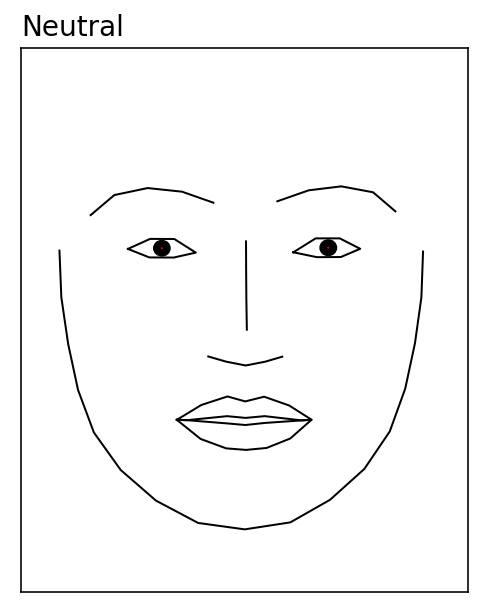

In [1]:
from feat.plotting import plot_face
import numpy as np

# 20 dimensional vector of AU intensities
# AUs ordered as:
# AU1, 2, 4, 5, 6, 7, 9, 10, 12, 14, 15, 17, 18, 20, 23, 24, 25, 26, 28, 43
neutral = np.zeros(20)

ax = plot_face(au=neutral, title='Neutral')

## 4.2 Plotting AU activations

Plotting facial expressions from AU activity is just as a simple. Below we increase the intensity of AU1 (inner brow raiser) to 3 before passing it to `plot_face()`. 

In general based on how our visualization model works, we don't recommend AU intensities greater than 3 as more exaggerated intensities can produce distorted facial expressions

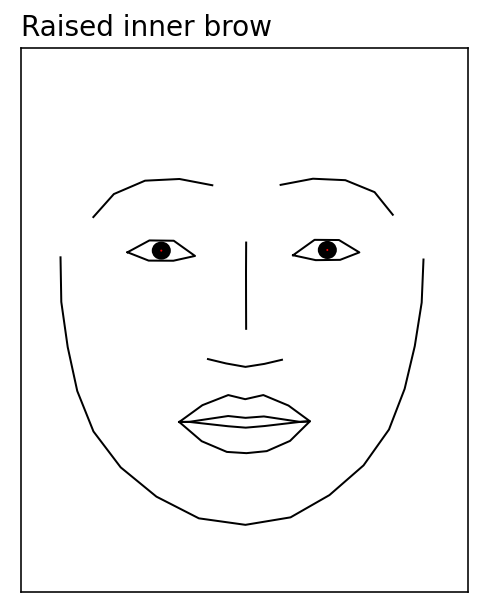

In [2]:
raised_inner_brow = np.zeros(20)
# Increase AU1 intensity: Inner brow raiser
raised_inner_brow[0] = 3

_ = plot_face(au=raised_inner_brow, title="Raised inner brow")

### Adding muscle heatmaps to the plot

We can also visualize how AU intensity affects the underyling facial muscle movement by passing in a dictionary of facial muscle names and colors (or the value `'heatmap'`) to `plot_face()`. 

Below we activate 2 AUs and use the key `'all'` with the value `'heatmap'` to overlay muscle movement intensities affected by these specific AUs:

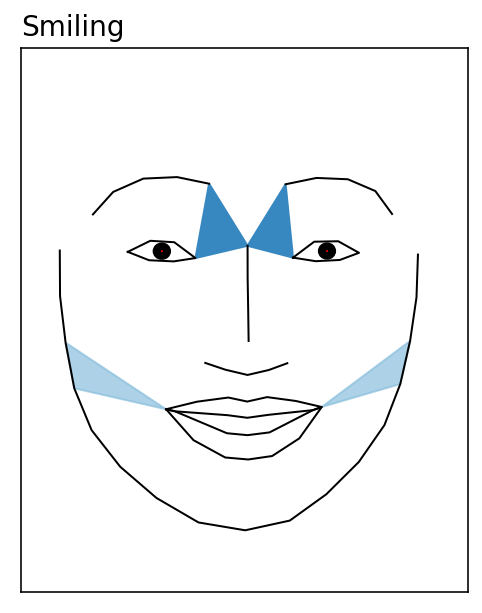

In [3]:
# Activate AUs
smiling = np.array([3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Overlay muscles 
muscles = {'all': 'heatmap'}

_ = plot_face(au = smiling, muscles = muscles, title='Smiling')

But it's also possibile to arbitrarily highlight any facial muscle by setting it to a color instead. This ignores the AU intensity and useful for highlighting specific facial muscles. Below we higlight two different muscles on a neutral face:

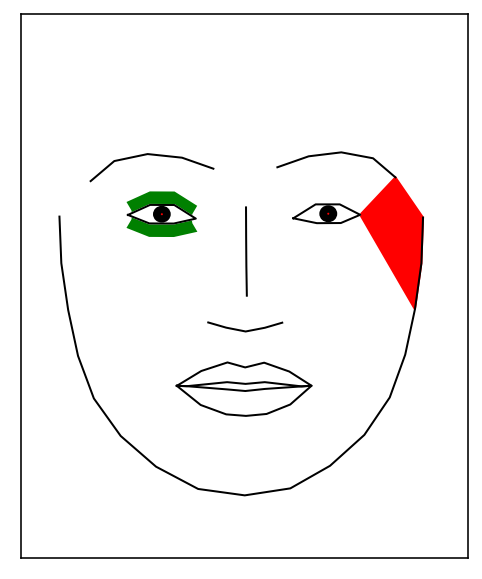

In [4]:
muscles = {'temporalis_r_rel': "red", 'pars_palp_l': 'green'}
_ = plot_face(au=neutral, muscles=muscles)

### Adding gaze vectors to the plot

Py-Feat also supports overlaying gaze vectors to indicate where the eyes are looking. By default the eyes are always in a neutral position pointing forward. But it's possible to pass an array to the `gaze` argument of `plot_face()` to move the eyes.  
Gaze vectors are length 4 `(lefteye_x, lefteye_y, righteye_x, righteye_y)` where the y orientation is positive for looking upwards.

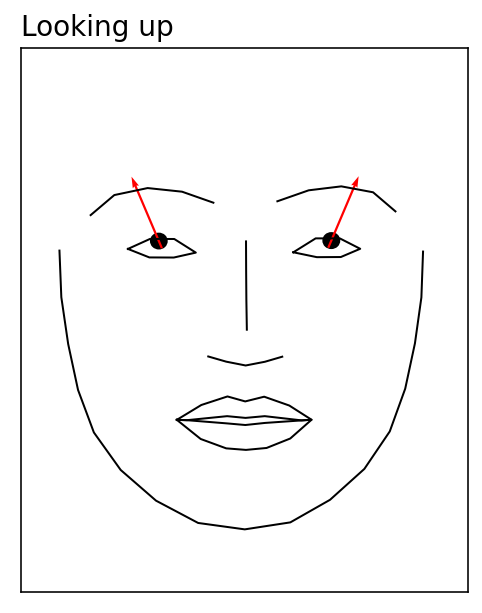

In [5]:
# Add some gaze vectors: (lefteye_x, lefteye_y, righteye_x, righteye_y)
gaze = [-1, 5, 1, 5]

_ = plot_face(au=neutral, gaze=gaze, title='Looking up')

### Adding vectorfield arrows to highlight facial movement

One way we can highlight how a faces change between two expressions is by overlaying a vectorfield of arrows for each facial landmark pointing in the direction of movement from one face to another. To do so, we use the `predict()` function to get landmark data for each array of AU intensities we want to plot and generate a `vectors` dictionary with keys for the `'target'` and `'reference'` faces. Then we can pass this dictionary to the `vectorfield` argument of `plot_face()`:

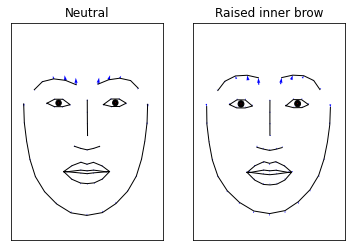

In [19]:
from feat.plotting import predict
import matplotlib.pyplot as plt

# Get landmarks
neutral_landmarks = predict(neutral)
raised_inner_brow_landmarks = predict(raised_inner_brow)

# Provide target landmarks and other vector specifications
netural_to_target = {
    "target": raised_inner_brow_landmarks,
    "reference": neutral_landmarks,
    "color": "blue",
}
target_to_neutral = {
    "target": raised_inner_brow_landmarks,
    "reference": neutral_landmarks,
    "color": "blue",
}

fig, axes = plt.subplots(1, 2)
# Vectorfield goes from neutral -> target on neutral face
_ = plot_face(ax=axes[0], au=neutral, title="Neutral", vectorfield=netural_to_target)
# Vectorfield goes target -> neutral on target face
_ = plot_face(
    ax=axes[1],
    au=raised_inner_brow,
    title="Raised inner brow",
    vectorfield=target_to_neutral,
)


## 4.3 Plotting with Fex data classes

While you can always use the `plot_face()` function directly by passing in AU intensities, you can also use the `.plot_aus()` method on Fex data classes to visualize data. Just pass in numerical index `i` referring to the AU you want to visualize. That index corresponds to the `ith` column of the `.au_columns` attribute of the Fex data class instance.

Below we pass in `12` which corresponds to AU20:

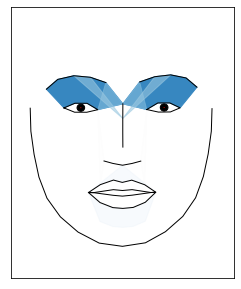

In [20]:
from feat.utils import get_test_data_path
from feat.utils import read_openface
from os.path import join

test_file = join(get_test_data_path(),'OpenFace_Test.csv')
openface = read_openface(test_file)

# 12th AU in Openface model is AU 20
_ = openface.plot_aus(12, muscles={'all': "heatmap"})

## 4.4 Animating facial expressions

Py-Feat includes an `animate_face()` function which makes it easy to "morph" one facial expression into another by interpolating between AU intensities. You can use this function in two ways:
1. Using the `AU` keyword argument and a single scalar value for `start` and `end`
2. Passing in 2 arrays of AU intensities for `start` and `end` 

The first style is mostly just a convenient way to visualize changes for a single AU. Below we use this style to animate raising of the inner brow:

In [33]:
from feat.plotting import animate_face

# Just pass in a FACS AU id, in this case we pass in 1 which is the inner brow raiser
animation = animate_face(
    AU=1, start=0, end=3, title="Raised inner brow", save="AU1.gif"
)

<IPython.core.display.Javascript object>

![](AU1.gif)

The second style is more flexible and behaves like `plot_face()`. It's generally more useful when multiple AUs change together. Below we use this style to visualize 2 AUs changing with different intensities. We also overlay muscle activations which change dynamically in the animation: 

In [32]:
# We reuse the AU arrays from above to morph between a neutral and smiling face
animation = animate_face(
    start=neutral,
    end=smiling,
    muscles={"all": "heatmap"},
    title='Smiling',
    save="smiling.gif",
)

<IPython.core.display.Javascript object>

![](../images/smiling.gif)

It's also possible to animate gaze directions using the `gaze_start` and `gaze_end` arguments to `animate_face()`. Here we pass the same neutral expression to `start` and `end` so the only thing being animates is gaze direction:

In [ ]:
animation = animate_face(
    start=neutral,
    end=neutral,
    gaze_start = [0,0,0,0],
    gaze_end = [-1, 5, 1, 5],
    title='Looking Up',
    save='looking_up.gif'
) 

![](../images/looking_up.gif)

### More complex animations

While `animate_face()` is useful for animating a single facial expression, sometimes you might want to make more complex multi-face animations. We can do that using `plot_face()` along with the `interpolate_aus()` helper function which will generate intermediate AU intensity values between two arrays in a manner that creates graceful animations ([cubic bezier easing function](https://easings.net/)).

We can easily make a grid of all 20 AUs and animate their intensity changes one at a time from a netural facial expression. To generate the animation from matplotlib plots, we use the [`celluloid`](https://github.com/jwkvam/celluloid) library that makes it a bit easier to work with matplotlib animations. It's also what `animate_face` uses under the hood: 

In [12]:
from feat.utils import RF_AU_presence # AU ids
from feat.plotting import interpolate_aus # cubic easing interpolation
from celluloid import Camera

# Link AU ids to their descriptions; might be wrong? see:
au_name_map = list(
    zip(
        RF_AU_presence,
        [
            "inner brow raiser",
            "outer brow raiser",
            "brow lowerer",
            "upper lid raiser",
            "cheek raiser",
            "lid tightener",
            "nose wrinkler",
            "upper lip raiser",
            "lip corner puller",
            "dimpler",
            "lip corner depressor",
            "chin raiser",
            "lip puckerer",
            "lip stretcher",
            "lip tightener",
            "lip pressor",
            "lips part",
            "jaw drop",
            "lip suck",
            "eyes closed",
        ],
    )
)

# Start all AUs at neutral
starting_intensities = np.zeros((20, 20))

# And eventually get to 3
ending_intensities = np.eye(20) * 3

# Define some animation settings
fps = 15
duration = 0.5
padding = 0.25
num_frames = int(np.ceil(fps * duration))

# Add some padding frames so when the animation loops it pauses on the endpoints
num_padding_frames = int(np.ceil(fps * padding))
total_frames = (num_frames + num_padding_frames) * 2

In [ ]:
# Loop over each frame of the animation, plot a 4 x 5 grid of faces
fig, axs = plt.subplots(4, 5, figsize=(12, 18))
camera = Camera(fig)

for frame_num in range(total_frames):
    for i, ax in enumerate(axs.flat):
        au_interpolations = interpolate_aus(
            start=starting_intensities[i, :],
            end=ending_intensities[i, :],
            num_frames=num_frames,
            num_padding_frames=num_padding_frames,
        )

        ax = plot_face(
            model=None,
            ax=ax,
            au=au_interpolations[frame_num],
            title=f"{au_name_map[i][0]}\n{au_name_map[i][1]}",
        )
    _ = camera.snap()

# Create the animation
animation = camera.animate()
animation.save("all.gif", fps=fps)

![](../images/all.gif)